<IPython.core.display.Javascript object>


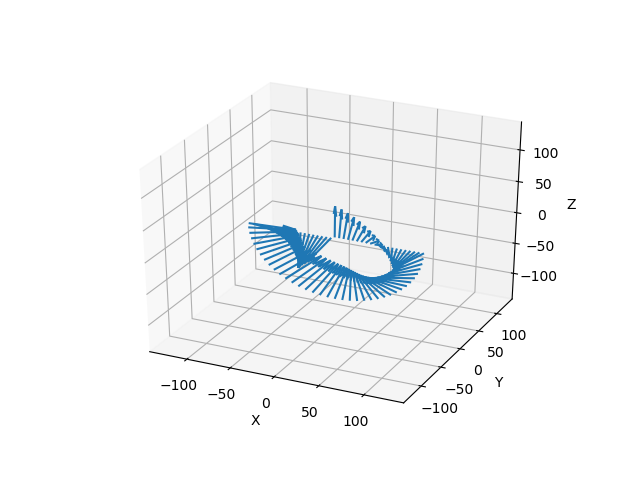

380 380


In [56]:
import numpy as np
from math import cos, sin, radians, degrees
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import animation
import math
import random 
import time
%matplotlib notebook

def RotY(deg):
    return np.array([[cos(deg),  0, sin(deg)],
                     [    0   ,  1,   0    ],
                     [-sin(deg), 0, cos(deg)]])

def RotZ(deg):
    return np.array([[cos(deg), -sin(deg),  0],
                     [sin(deg), cos(deg) ,  0],
                     [0       , 0        ,  1]])
def RotX(deg):
    return np.array([[1,    0    ,     0    ],
                     [0, cos(deg), -sin(deg)],
                     [0, sin(deg),  cos(deg)]])

def create_simulated_data():
    gt_pos = [] #x, y, z
    gt_rot = [] #x, y, z euler degrees
    
    
    #movement to the right
    x = np.array([[0,0,0]]).T
    for i in range(100):
        gt_pos.append(x)
        x = x+np.array([[1,0,0]]).T
    
    #circular movement
    for i in range(180):
        a = radians(i)
        R = RotY(a)
        x_r = R.dot(x)
        gt_pos.append(x_r)
    
    #movement to the left
    x = x_r
    for i in range(100):
        x = x+np.array([[1,0,0]]).T
        gt_pos.append(x)
        
    #rotation
    r_x, r_y, r_z = 0,0,0
    r_x_v, r_y_v, r_z_v = 1,1,1
    for i in range(380):
        if i > 240 and r_x_v==1: r_x_v *=-1
        if i > 100 and r_z_v==1: r_z_v *=-1
        r_x += r_x_v
        r_y += r_y_v
        r_z += r_z_v
        gt_rot.append(np.array([[r_x, r_y, r_z]]).T)
        
    return gt_pos, gt_rot

def animate_moevement(gt_pos, gt_rot):
    #https://stackoverflow.com/questions/19329039/plotting-animated-quivers-in-python
    #https://github.com/anujgupta82/Musings/blob/master/Dynamic%20or%20Live%20update%20of%20a%20Plot.ipynb
    fig = plt.figure()
    ax = fig.add_subplot(111,projection='3d')
    def set_axis():
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_zlabel('Z')
        ax.set_xlim(-120 ,120)
        ax.set_ylim(-120 ,120)
        ax.set_zlim(-120 ,120)
    h_v = np.array([[0,0,50]]).T#heading vector
    plt.ion()
    fig.show()
    fig.canvas.draw()
    
    print len(gt_pos), len(gt_rot)
    for i in range(0,len(gt_pos), 5):
        pos = gt_pos[i]
        rot = gt_rot[i]
        if animate_moevement.DO_CLEAR_FIGURE:
            ax.clear()
        x, y, z =pos[0],pos[1],pos[2]
        rx, ry, rz = math.radians(rot[0]),math.radians(rot[1]),math.radians(rot[2])
        R = RotY(ry).dot(RotX(rx)).dot(RotZ(rz))
        hv_r = R.dot(h_v)
        ax.quiver(x,y,z,hv_r[0],hv_r[1],hv_r[2])
        set_axis()
        fig.canvas.draw()   # draw
        time.sleep(0.05)    #sleep

    plt.show()

gt_pos, gt_rot = create_simulated_data()
animate_moevement.DO_CLEAR_FIGURE = False
animate_moevement(gt_pos, gt_rot)

In [100]:
import numpy as np
from numpy.linalg import norm
from numpy import array
from math import cos, sin
import quaternion
from utils.quatutils import Eul_FromQuat, EulOrdZXYs

class UKF_tracker:
    #https://pdfs.semanticscholar.org/3085/aa4779c04898685c1b2d50cdafa98b132d3f.pdf
    def __init__(self):
        pass
    
    def fx(self, x, dt):
        qk  = x[:4,0 ]   #quaternion
        wk  = x[4:7]   #angular velocity
        pk  = x[7:10]  #position
        vk  = x[10:13] #velocity
        
        a_d  = norm(wk) * dt
        e_d  = wk / norm(wk) if norm(wk) > 0.01 else wk
        e_d_ = e_d * sin(a_d/2)
        a_d_ = cos(a_d/2.0)

        q_d = np.quaternion(a_d_, e_d_[0],e_d_[1],e_d_[2] )
        qk  = quaternion.as_quat_array(qk)
        qk_ = qk * q_d
        qk_ = quaternion.as_float_array(qk_).reshape(-1,1)
        
        wk_ = wk
        
        pk_ = pk + vk
        vk_ = vk
        
        x_ = np.vstack((qk_, wk_, pk_, vk_))
        return x_
    
    def hx(self, x):
        qk_ = x[:4,0]
        qk_ = qk_[1],qk_[2],qk_[3], qk_[0]              #quaternion package has  w,x,y,z as in blender
        euler_ZXY = Eul_FromQuat(qk_, EulOrdZXYs())[:3] #conversion function has x,y,z,w
        yaw   = euler_ZXY[2]
        pitch = euler_ZXY[1]
        roll  = euler_ZXY[0]        

        print yaw, pitch, roll
        
        
        
tracker = UKF_tracker()
x = array([[1,0,0,0, 0,0,0, 0,0,0, 0,0,0]]).T.astype(np.float32)
tracker.fx(x, 1)

x = array([[1,0,0,0, 0,0,0, 0,0,0, 0,0,0]]).T.astype(np.float32)
x[1] = -0.0353418551 #x
x[2] = 0.0153527753 #y
x[3] = 0.0052260263 #z
x[0] = -0.9992436767 #w
tracker.hx(x)
        

-1.7838548 4.0409703 -0.6622435
